# Recognizing traffic signs using Convnets
## Description
This project takes advantage of Convnets to recognize traffic signs, in which Convnets will be trained from scratch using Tensorflow.
## Dataset
The dataset using in this project is German Traffic Sign Recognition Benchmark (GTSRB), taken from Institut für Neuroinformatik.

Downloaded link: http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

On Linux systems: wget -q http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip

In [1]:
# define general params
num_classes = 43
resized_image = (32, 32)

# define the random seed
seed = 101
np.random.seed(seed)

In [3]:
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np

%matplotlib inline

## Load the dataset

In [4]:
# create a new object dataset
dataset = namedtuple('dataset', ['X', 'y'])

In [5]:
# convert each image to a 3D vector, and concatenate all of them along the axis=0 
def to_tf_format(imgs):
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis=0).astype(np.float32)

In [10]:
# function to read the dataset 
def read_dataset_ppm(rootpath, n_labels, resize_to):
    images = []
    labels = []
    
    for c in range(n_labels):
        full_path = rootpath + '/' + format(c, '05d') + '/'
        
        for img_name in glob.glob(full_path + '*.ppm'):
            img = plt.imread(img_name).astype(np.float32)
            img = rgb2lab(img/255.0)[:,:,0]
            
            if resize_to:
                img = resize(img, resize_to, mode='reflect') # points outside the boundaries of the input are filled according to 'reflect' mode
            
            # one-hot encoding labels manually
            label = np.zeros((n_labels, ), dtype=np.float32)
            label[c] = 1.0
            
            images.append(img.astype(np.float32))
            labels.append(label)
            
    return dataset(X=to_tf_format(images).astype(np.float32),
                  y=np.matrix(labels).astype(np.float32))

In [11]:
# read the dataset
dataset = read_dataset_ppm('./data/GTSRB/Final_Training/Images', num_classes, resized_image)

# examine the dataset
print(dataset.X.shape)
print(dataset.y.shape)

(39209, 32, 32, 1)
(39209, 43)


[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


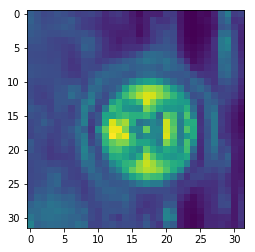

In [18]:
# show a sample image from the dataset
plt.imshow(dataset.X[0, :, :, :].reshape(resized_image))
print(dataset.y[0, :])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


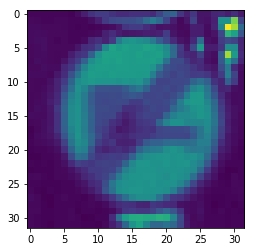

In [19]:
# show the last image from the dataset
plt.imshow(dataset.X[-1, :, :, :].reshape(resized_image))
print(dataset.y[-1, :])

## Split the dataset into training and testing datasets

In [21]:
# split the dataset into training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset.X, dataset.y, test_size=0.25, random_state=42)

# examine the shape of the new 4 datasets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(29406, 32, 32, 1)
(9803, 32, 32, 1)
(29406, 43)
(9803, 43)


## Build the neural network with Tensorflow

In [22]:
# create minibatch
def minibatcher(X, y, batch_size, shuffle):
    assert(X.shape[0] == y.shape[0])
    n_samples = X.shape[0]
    
    if shuffle:
        idx = np.random.permutation(n_samples)
    else:
        idx = list(range(n_samples))
    
    for k in range(int(np.ceil(n_samples/batch_size))):
        from_idx = k*batch_size
        to_idx = (k+1)*batch_size
        yield X[idx[from_idx:to_idx], :, :, :], y[idx[from_idx:to_idx], :]

In [27]:
# print minibatch yielded from minibatcher
for minibatch in minibatcher(X_train, y_train, 10000, shuffle=True):
    print(minibatch[0].shape, minibatch[1].shape) # minibatch[0] is input and [1] is output

(10000, 32, 32, 1) (10000, 43)
(10000, 32, 32, 1) (10000, 43)
(9406, 32, 32, 1) (9406, 43)


In [42]:
import tensorflow as tf

# fully-connected layer without activation
def fc_wo_activation_layer(in_tensors, n_units):
    w = tf.get_variable('fc_W', 
        [in_tensors.get_shape()[1], n_units],
        tf.float32,
        tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('fc_B',
        [n_units, ],
        tf.float32,
        tf.constant_initializer(0.0))
    return tf.matmul(in_tensors, w) + b

# apply leakyRELU activation to fully-connected layer
def fc_layer(in_tensors, n_units):
    return tf.nn.leaky_relu(fc_wo_activation_layer(in_tensors, n_units))

# max-pooling layer
def maxpool_layer(in_tensors, sampling):
    return tf.nn.max_pool(in_tensors, [1, sampling, sampling, 1],  [1, sampling, sampling, 1], 'SAME')

# convolutional layer
def conv_layer(in_tensors, kernel_size, n_units):
    w = tf.get_variable('conv_W',
                       [kernel_size, kernel_size, in_tensors.get_shape()[3], n_units],
                       tf.float32,
                       tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('conv_B',
                       [n_units, ],
                       tf.float32,
                       tf.constant_initializer(0.0))
    
    return tf.nn.leaky_relu(tf.nn.conv2d(in_tensors, w, [1, 1, 1, 1], 'SAME') + b)

# dropout
def dropout(in_tensors, keep_proba, is_training):
    return tf.cond(is_training, lambda: tf.nn.dropout(in_tensors, keep_proba), lambda: in_tensors)

# build the model
def model(in_tensors, is_training):
    # first layer: 5x5 2d-conv, 32 filters, 2x maxpool, 20% dropout
    with tf.variable_scope('l1'):
        l1 = maxpool_layer(conv_layer(in_tensors, 5, 32), 2)
        l1_out = dropout(l1, 0.8, is_training)
  
    # second layer: 5x5 2d-conv, 64 filters, 2x maxpool, 20% dropout
    with tf.variable_scope('l2'):
        l2 = maxpool_layer(conv_layer(l1_out, 5, 64), 2)
        l2_out = dropout(l2, 0.8, is_training)

    with tf.variable_scope('flatten'):
        l2_out_flat = tf.layers.flatten(l2_out)

    # fully collected layer, 1024 neurons, 40% dropout 
    with tf.variable_scope('l3'):
        l3 = fc_layer(l2_out_flat, 1024)
        l3_out = dropout(l3, 0.6, is_training)

    # Output
    with tf.variable_scope('out'):
        out_tensors = fc_wo_activation_layer(l3_out, num_classes)

    return out_tensors

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

def train_model(X_train, y_train, X_test, y_test, learning_rate, max_epochs, batch_size):
    in_X_tensors_batch = tf.placeholder(tf.float32, shape = (None, resized_image[0], resized_image[1], 1))
    in_y_tensors_batch = tf.placeholder(tf.float32, shape = (None, num_classes))
    is_training = tf.placeholder(tf.bool)
    
    logits = model(in_X_tensors_batch, is_training)
    out_y_pred = tf.nn.softmax(logits)
    loss_score = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=in_y_tensors_batch)
    loss = tf.reduce_mean(loss_score)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        
        for epoch in range(max_epochs):
            print("Epoch=", epoch)
            tf_score = []

            for minibatch in minibatcher(X_train, y_train, batch_size, shuffle = True):
                tf_output = session.run([optimizer, loss], 
                                        feed_dict = {in_X_tensors_batch : minibatch[0], 
                                                     in_y_tensors_batch : minibatch[1],
                                                     is_training : True})
                
                tf_score.append(tf_output[1])
            print(" train_loss_score=", np.mean(tf_score))
    
        # test the performace of the model on the testing set
        print("TEST SET PERFORMANCE")
        y_test_pred, test_loss  = session.run([out_y_pred, loss], 
                                              feed_dict = {in_X_tensors_batch : X_test, 
                                                           in_y_tensors_batch : y_test,
                                                           is_training : False})

        print(" test_loss_score=", test_loss)
        y_test_pred_classified = np.argmax(y_test_pred, axis=1).astype(np.int32)
        y_test_true_classified = np.argmax(y_test, axis=1).astype(np.int32)
        print(classification_report(y_test_true_classified, y_test_pred_classified))

        cm = confusion_matrix(y_test_true_classified, y_test_pred_classified)

        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

        # And the log2 version, to enphasize the misclassifications
        plt.imshow(np.log2(cm + 1), interpolation='nearest', cmap=plt.get_cmap("tab20"))
        plt.colorbar()
        plt.tight_layout()
        plt.show()

Epoch= 0
 train_loss_score= 4.8184233
Epoch= 1
 train_loss_score= 0.78672546
Epoch= 2
 train_loss_score= 0.3658465
Epoch= 3
 train_loss_score= 0.21201918
Epoch= 4
 train_loss_score= 0.15547252
Epoch= 5
 train_loss_score= 0.11006028
Epoch= 6
 train_loss_score= 0.083629854
Epoch= 7
 train_loss_score= 0.0797572
Epoch= 8
 train_loss_score= 0.0677111
Epoch= 9
 train_loss_score= 0.059890416
TEST SET PERFORMANCE
 test_loss_score= 0.05197122
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        44
           1       1.00      0.99      0.99       594
           2       0.98      0.99      0.99       560
           3       0.99      0.94      0.97       348
           4       1.00      1.00      1.00       529
           5       0.98      0.97      0.97       462
           6       0.99      1.00      0.99        81
           7       1.00      0.99      0.99       336
           8       0.97      1.00      0.98       385
           9       0.

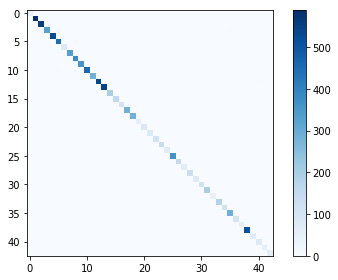

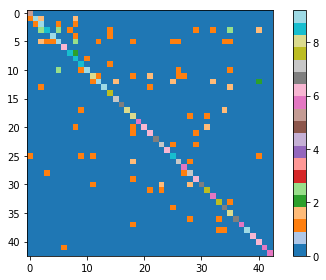

In [47]:
# start to run the model
tf.reset_default_graph()
train_model(X_train, y_train, X_test, y_test, 0.001, 10, 256)